# Simulation Based Inference for simple Hidden Markov Models
This notebook is designed to demonstrate the functionality of Simulation Based Inference (`SBI`) in the case of Hidden Markov Models (HMMs). HMMs are a time-series measure with interdependent data points, meaning individual data points are not i.i.d. and since `SBI` deals with i.i.d. data, we need to treat the entire time-series as a single data point. For this case, our simulator (`HMM_gen`) outputs an entire dataset in a prespecified format. The nr of features and nr of measurements are fixed in the simulator, but can of course be altered there manually to accomodate different datasets with differing characteristics.

In [2]:
import numpy as np
from HMM_gen import HMM_gen, HMM_wrap_sbi
import torch
from sbi import utils as utils
from sbi.inference.base import infer

## Create an sbi object for amortized inference using SNPE
It is important that we first define the characteristics of our data set. An HMM required definition of the number of different discrete states that can be occupied (S=3), and the nr of features that are measured at each time point (M=3). We are also going to assume that each feature is normally distributed. All of these 'meta'-parameters are pre-defined in our simulator, `HMM_gen`. However, since `sbi` only takes single vector parameter inputs, we have to wrap our simulator using a function that reconstructs the means, variances, and transition probabilities from a single parsed vector. This wrapping is taken care of with `HMM_wrap_sbi`. Since we are estimating the means, variances, and transition probabilities, we have 24 degrees of freedom in our parameter vector. We will specify a prior distribution that is uniform over the range <-4, 4> for the means, <0, 4> for the variances, and <-4, 4> for logit transformed transition probabilities.

In [3]:
num_dim = 24
prior = utils.BoxUniform(low = torch.from_numpy(np.concatenate([-4*np.ones(9), np.zeros(9), -4*np.ones(6)])), 
                         high = 4*torch.ones(num_dim))
posterior = infer(HMM_wrap_sbi, prior, method='SNPE', num_simulations=10000, num_workers=20)

/home/sven/miniconda3/envs/HMM_sbi/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


Neural network successfully converged after 22 epochs.


## Generate an 'empirical' observation
We have now simple created a network for amortized inference over our HMM simulator, given our specified prior. Now, lets specify the real population means and generate some data. This data would correspond to data that is collected e.g. during a scientific experiment. Our simulator returns a matrix of [Observations x Features], but `sbi` only deals with one-dimensional output. However, we can simply flatten our matrix without sacrificing any of the information regarding features and observations.

In [4]:
# Set up the parameters of the 'true' HMM
mus = np.array([[0.1, 1.1, 2.1],
                [2.1, 0.1, 1.1],
                [-3,  -2,  -1 ]])
sds = np.array([[0.5, 0.5, 0.5],
                [0.5, 0.5, 0.5],
                [0.5,0.5,0.5]])
TPM = np.array([[0.9, 0.05, 0.05],
                [0.05, 0.9, 0.05],
                [0.05, 0.05, 0.9]])
delta = [1,0,0]
N = 1800

# Generate the 'observed' experimentally collected data from the HMM
x_0 = HMM_gen(mus=mus, sds=sds, TPM=TPM, N=N, delta=delta).flatten()

## Sample from the posterior w.r.t. observation
Now, we use our empirical obsevation to inspect the posterior distribution of the parameters of the simulator.

In [14]:
samples = posterior.sample((10000,), x=x_0)

log_probability = posterior.log_prob(samples, x=x_0)

## Plot posteriors of parameters
Now, we plot some of the posteriors of the parameters of our simulator, given the generated empirical data.

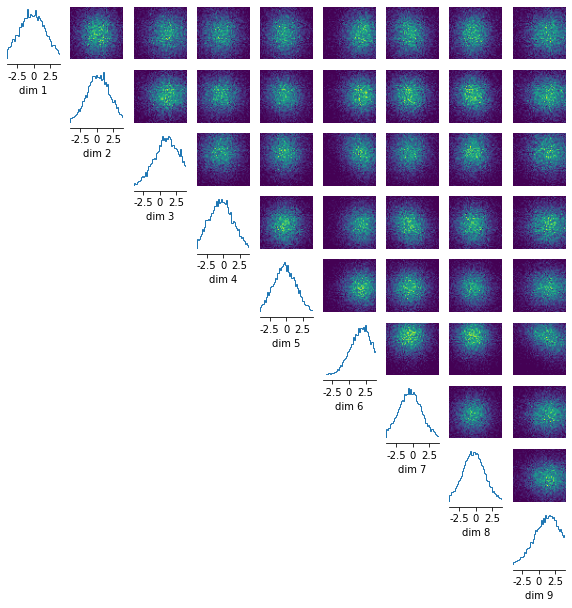

In [15]:
_ = utils.pairplot(samples[:,0:9])

## Increase the nr of simulations for posterior estimation with SNPE
Inspect the accuracy increase of a longer runtime

In [16]:
num_dim = 24
prior = utils.BoxUniform(low = torch.from_numpy(np.concatenate([-4*np.ones(9), np.zeros(9), -4*np.ones(6)])), 
                         high = 4*torch.ones(num_dim))
posterior = infer(HMM_wrap_sbi, prior, method='SNPE', num_simulations=100000, num_workers=20)


Neural network successfully converged after 25 epochs.


In [19]:
samples = posterior.sample((100000,), x=x_0)

log_probability = posterior.log_prob(samples, x=x_0)

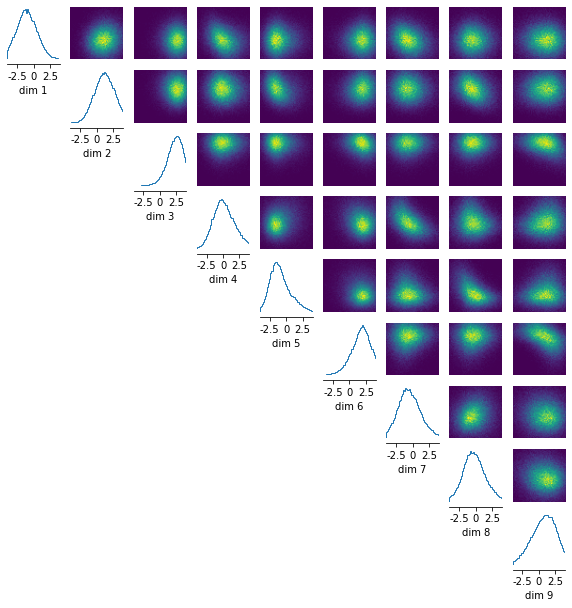

In [20]:
_ = utils.pairplot(samples[:,0:9])

## Change the procedure to SNRE
Inspect the changes for using a different estimation procedure

In [5]:
num_dim = 24
prior = utils.BoxUniform(low = torch.from_numpy(np.concatenate([-4*np.ones(9), np.zeros(9), -4*np.ones(6)])), 
                         high = 4*torch.ones(num_dim))
posterior = infer(HMM_wrap_sbi, prior, method='SNRE', num_simulations=100000, num_workers=20)


Neural network successfully converged after 40 epochs.


In [6]:
samples = posterior.sample((10000,), x=x_0)

log_probability = posterior.log_prob(samples, x=x_0)

Generating samples: 100%|██████████| 10000/10000 [3:05:58<00:00,  1.12s/it] 
/home/sven/miniconda3/envs/HMM_sbi/lib/python3.8/site-packages/sbi/inference/posteriors/ratio_based_posterior.py:122: UserWarning: The log probability from SNRE_B is only correct up to a normalizing constant.
  warn(


In [ ]:
_ = utils.pairplot(samples[:,0:9])

# Conclusion
Label switching is still screwing everything over as usual